# Tutoriel : Visualisation de données électorales avec GeoPandas en Python

Dans ce tutoriel, nous allons apprendre à utiliser **GeoPandas** pour visualiser des données électorales sur une carte. Nous allons travailler avec :

1. Un fichier CSV contenant des résultats électoraux en Mauritanie (élections 2019–2024) :
   - [results_elections_rim_2019-2024.csv](https://raw.githubusercontent.com/binorassocies/rimdata/refs/heads/main/data/results_elections_rim_2019-2024.csv)
2. Un shapefile des divisions administratives (Moughataas) de Mauritanie :
   - [mrt_adm_ansade_20240327_ab_shp.zip](https://data.humdata.org/dataset/8d49f50d-92a8-46d9-9462-f821a8058f6d/resource/dacb6ad2-13b6-4f14-b1e9-44b800d76e58/download/mrt_adm_ansade_20240327_ab_shp.zip)

Nous allons explorer comment :

1. Charger et manipuler un shapefile avec GeoPandas.
2. Charger et fusionner des données CSV avec le shapefile.
3. Visualiser les résultats électoraux pour l'élection de 2024, par moughataa.
4. Personnaliser l'affichage (couleurs, titres, légendes, etc.).

## Prérequis
- Python 3.x
- GeoPandas (et ses dépendances)
- Pandas, Matplotlib
- Jupyter Notebook (ou JupyterLab)

---
## Installation

Si vous utilisez Anaconda/Miniconda, vous pouvez installer GeoPandas avec :
```
conda install -c conda-forge geopandas
```

Sinon, via pip (assurez-vous d'avoir les dépendances nécessaires comme `gdal`, `fiona`, `shapely`, etc.) :
```
pip install geopandas
```

---
## Chargement des bibliothèques


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

#plt.style.use('seaborn-white')  # Style de base pour les graphiques
%matplotlib inline

## Chargement du shapefile

Le shapefile de la Mauritanie peut être téléchargé depuis le lien ci-dessus. Décompressez le fichier `mrt_adm_ansade_20240327_ab_shp.zip` localement. Il contient plusieurs fichiers (.shp, .dbf, .shx, etc.) qui définissent la géométrie et les attributs des **Moughataas** (régions administratives).

Pour cet exemple, nous supposons que vous avez décompressé ces fichiers dans un dossier `data/`. Nous allons charger le fichier `.shp` principal avec GeoPandas.

In [3]:
# Par exemple, si le shapefile principal est nommé 'mrt_admbnda_adm2_20240327_AB.shp'

shapefile_path = "mrshape/mrt_admbnda_adm2_ansade_20240327.shp"  # À adapter selon le nom exact du fichier
gdf_moughataas = gpd.read_file(shapefile_path)

gdf_moughataas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ADM2_EN     63 non-null     object        
 1   ADM2_PCODE  63 non-null     object        
 2   ADM2_REF    14 non-null     object        
 3   ADM1_EN     63 non-null     object        
 4   ADM1_PCODE  63 non-null     object        
 5   ADM0_EN     63 non-null     object        
 6   ADM0_PCODE  63 non-null     object        
 7   date        63 non-null     datetime64[ms]
 8   validOn     63 non-null     datetime64[ms]
 9   validTo     0 non-null      datetime64[ms]
 10  Shape_Leng  63 non-null     float64       
 11  Shape_Area  63 non-null     float64       
 12  AREA_SQKM   63 non-null     float64       
 13  geometry    63 non-null     geometry      
dtypes: datetime64[ms](3), float64(3), geometry(1), object(7)
memory usage: 7.0+ KB


Vous devriez obtenir un GeoDataFrame contenant des colonnes comme `ADM2_EN`, `ADM2_PCODE`, ou d'autres informations se rapportant aux Moughataas. Vérifiez le nom de la colonne qui contient le nom des Moughataas en français ou en arabe.

Par exemple, la colonne s'appelera peut-être `ADM2_EN`. Nous allons partir du principe que cette colonne contient le nom de la Moughataa.


## Chargement des données CSV

Le fichier CSV (results_elections_rim_2019-2024.csv) contient (a priori) les résultats des élections de 2019 à 2024 en Mauritanie. Nous allons le charger avec Pandas. Ensuite, nous allons filtrer les données pour ne conserver que celles de l'élection de 2024.


In [4]:
csv_url = "https://raw.githubusercontent.com/binorassocies/rimdata/refs/heads/main/data/results_elections_rim_2019-2024.csv"
df_elections = pd.read_csv(csv_url)

df_elections_2024 = df_elections[df_elections['year'] == 2024]  # Filtrage sur l'année 2024
df_elections_2024.head()

,year,election,wilaya,moughataa,commune,candidate,registered_voters,nb_null_votes,nb_neutral_votes,nb_votes
25769,2024,Presidential,Adrar,Aoujeft,Aoujeft,Biram Dah Abeid,3240,34,15,119
25770,2024,Presidential,Adrar,Aoujeft,Aoujeft,El Id Mohameden M’Bareck,3240,34,15,104
25771,2024,Presidential,Adrar,Aoujeft,Aoujeft,Hamadi Sid’El Moctar Mohamed Abdi,3240,34,15,183
25772,2024,Presidential,Adrar,Aoujeft,Aoujeft,Mamadou Bocar Ba,3240,34,15,2
25773,2024,Presidential,Adrar,Aoujeft,Aoujeft,Mohamed Cheikh Ghazouani,3240,34,15,1193


Vérifiez la structure de `df_elections_2024`. Vous devriez voir des colonnes indiquant la Moughataa, le candidat, le nombre de voix, etc. Dans ce tutoriel, nous allons supposer les noms de colonnes suivants (à adapter en fonction de vos données réelles) :

- `moughataa` : le nom de la Moughataa
- `candidate` : le nom du candidat
- `nb_votes` : le nombre de voix reçues par ce candidat dans cette Moughataa
- `year` : l'année de l'élection

## Agrégation et pivot des données

Nous voulons afficher la répartition des voix **par candidat** et **par Moughataa** pour 2024. Pour simplifier, on va fusionner directement le shapefile avec un DataFrame qui contient la somme des voix par candidat.

### Option 1 : Fusion directe et création de cartes multiples
Nous pouvons, pour chaque candidat, filtrer et fusionner les données sur la Moughataa, puis afficher une carte.

### Option 2 : Pivot et creation d'un DataFrame large
On peut aussi créer un pivot de la forme : Moughataa en index, Candidats en colonnes, Voix en valeurs, puis fusionner avec le shapefile. Ensuite, on pourrait tracer la carte pour chaque colonne/candidat.

Ici, nous allons illustrer la **première option** (multicartes) pour plus de lisibilité.


## Fusion des données

Pour fusionner, on a besoin d'une clé commune. Nous allons comparer la colonne du shapefile (par ex. `ADM2_EN`) avec la colonne `moughataa` du CSV, et effectuer un merge.

> **Remarque** : Les noms de Moughataas peuvent ne pas correspondre exactement (accents, différences d'orthographe, etc.). Dans un cas réel, vous devrez peut-être normaliser ces noms (ex. tout en majuscules, enlever les accents, etc.) avant de faire la jointure.

Pour cet exemple, nous allons supposer qu'ils correspondent directement.


In [5]:
# Pour faciliter, je vais renommer la colonne ADM2_EN en 'moughataa' si c'est la bonne colonne

gdf_moughataas = gdf_moughataas.rename(columns={"ADM2_EN": "moughataa"})  # À adapter
list(gdf_moughataas.moughataa)

['Ouadane',
 'Atar',
 'Aoujeft',
 'Chinguitti',
 'Guerou',
 'Kiffa',
 'Boumdeid',
 'Kankoussa',
 'Barkéol',
 'Magtalahjar',
 'Bababé',
 'Maal',
 'M’Bagne',
 'Aleg',
 'Boghé',
 'Nouadhibou',
 'Chami',
 'Kaedi',
 'M’Bout',
 'Lexeibe 1',
 'Maghama',
 'Mounguel',
 'Wompou',
 'Sélibaby',
 'Ghabou',
 'Ould Yengé',
 'Djiguenni',
 'Adel Bagrou',
 'Oualata',
 'N’Beiket Lehwach',
 'Timbédra',
 'Bassiknou',
 'Néma',
 'Amourj',
 'Tamchekett',
 'Aïoun',
 'Kobeni',
 'Touil',
 'Tintane',
 'Bennechab',
 'Akjoujt',
 'Toujounine',
 'Dar Naïm',
 'Teyarett',
 'Sebkha',
 'Ksar',
 'Tevragh Zeina',
 'Arafat',
 'El Mina',
 'Riad',
 'Moudjeria',
 'Tichit',
 'Tidjikja',
 'Bir Moughrein',
 'Zoueirat',
 'F’Deirick',
 'Tekane',
 'Boutilimit',
 'Keur Macen',
 'Ouad Naga',
 'Mederdra',
 'R’Kiz',
 'Rosso']

Ensuite, nous allons regrouper les données de 2024 par `moughataa` et `candidat` pour avoir la somme des voix (si nécessaire).

In [6]:
# Agrégation des voix par Moughataa et par candidat
df_agg_2024 = df_elections_2024.groupby(["moughataa", "candidate"], as_index=False)["nb_votes"].sum()
df_agg_2024.head()

,moughataa,candidate,nb_votes
0,Adel Bagrou,Biram Dah Abeid,755
1,Adel Bagrou,El Id Mohameden M’Bareck,79
2,Adel Bagrou,Hamadi Sid’El Moctar Mohamed Abdi,562
3,Adel Bagrou,Mamadou Bocar Ba,24
4,Adel Bagrou,Mohamed Cheikh Ghazouani,9757


### Visualisation pour chaque candidat

Nous allons maintenant :
1. Lister les candidats.
2. Pour chaque candidat, filtrer `df_agg_2024`.
3. Fusionner avec `gdf_moughataas`.
4. Afficher la carte.

Ensuite, nous verrons comment personnaliser l'apparence (couleurs, labels, légendes, etc.).


In [7]:
# Liste unique des candidats en 2024
candidats_2024 = df_agg_2024["candidate"].unique()
candidats_2024

array(['Biram Dah  Abeid', 'El Id Mohameden M’Bareck',
       'Hamadi Sid’El Moctar Mohamed Abdi', 'Mamadou Bocar Ba',
       'Mohamed Cheikh Ghazouani', 'Mohamed Lemine El Mourteji  El Wavi',
       'Outouma Antoine Souleymane Soumaré'], dtype=object)

#### Boucle sur les candidats


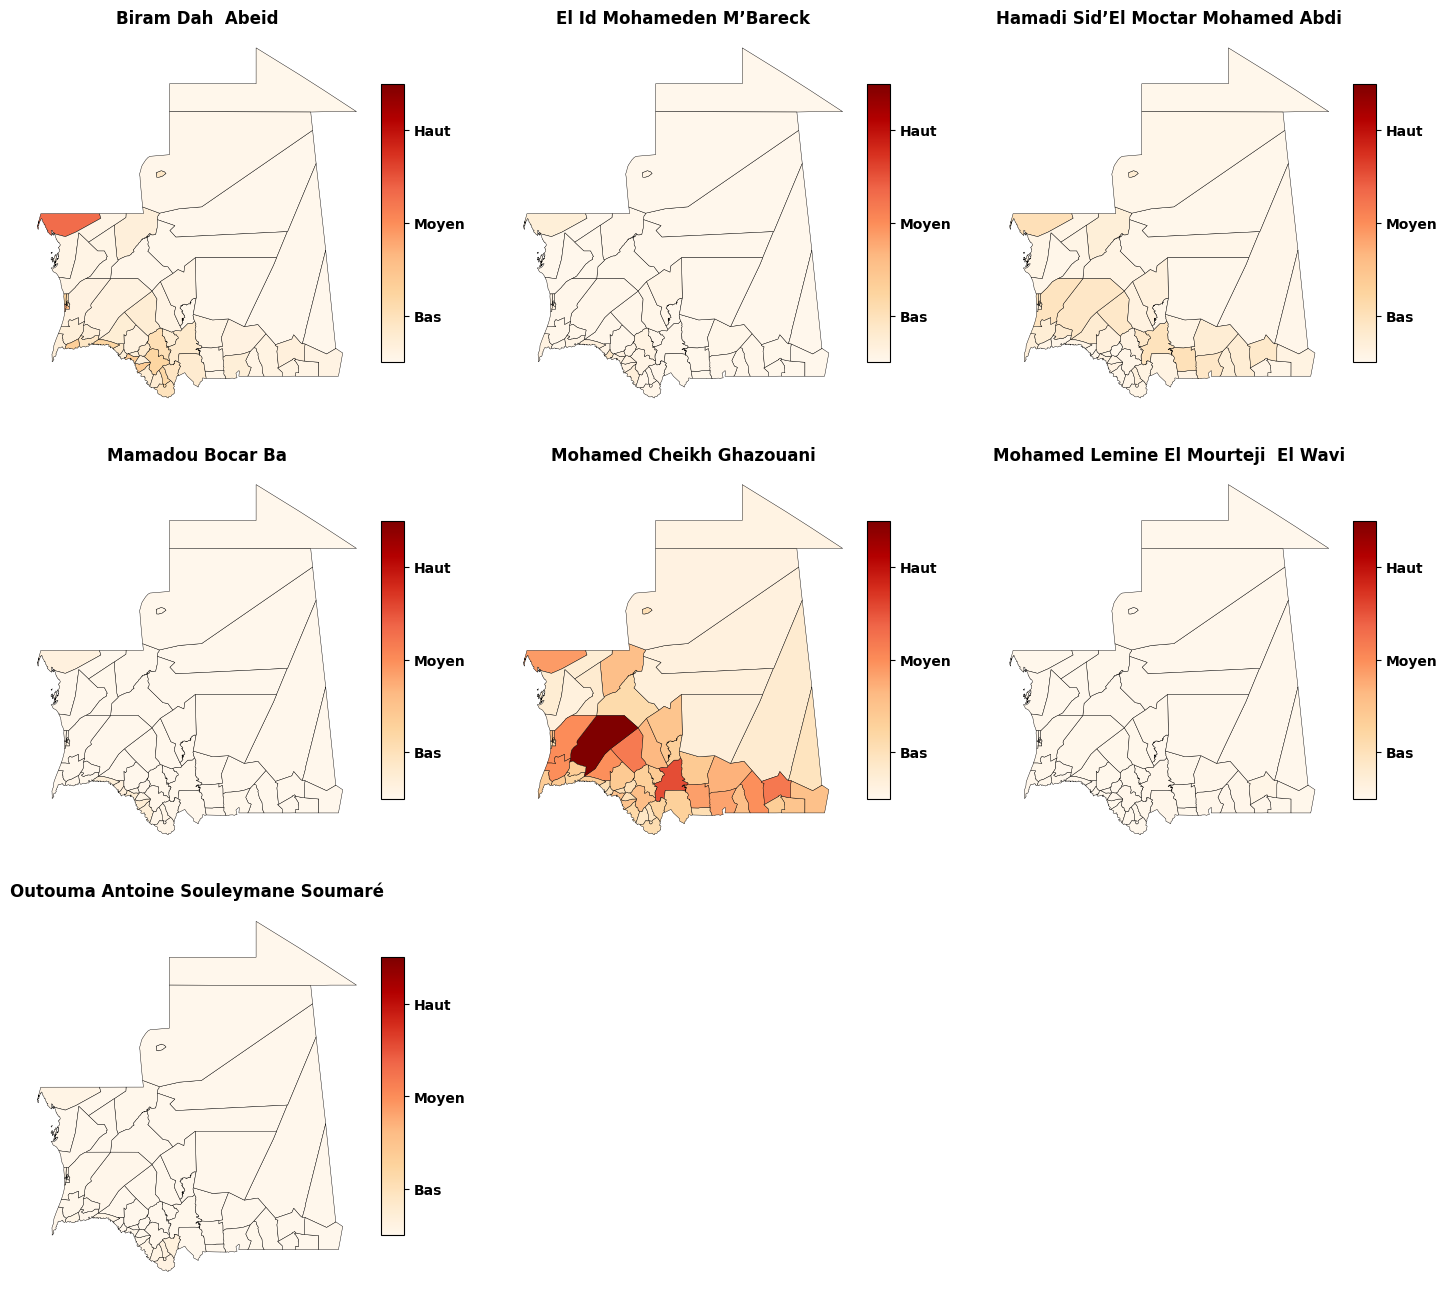

In [20]:
import matplotlib.pyplot as plt
import math

# 1. Échelle commune
vmin = 0
vmax = 30000

# 2. Configuration de la grille
candidats_2024 = df_agg_2024["candidate"].unique()
n_candidats = len(candidats_2024)
n_cols = 3
n_rows = math.ceil(n_candidats / n_cols)

# On garde une hauteur raisonnable pour ne pas trop espacer verticalement
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5.5 * n_rows))
axes = axes.flatten()

# Espacement réduit entre les cartes
plt.subplots_adjust(wspace=0.15, hspace=0.1)

for i, candidat in enumerate(candidats_2024):
    ax = axes[i]

    df_candidat = df_agg_2024[df_agg_2024["candidate"] == candidat].copy()
    gdf_merged = gdf_moughataas.merge(df_candidat, on="moughataa", how="left")

    # Affichage de la carte
    gdf_merged.plot(
        column="nb_votes",
        cmap="OrRd",
        vmin=vmin,
        vmax=vmax,
        legend=True,
        legend_kwds={
            'shrink': 0.7,      # AUGMENTÉ : La barre est plus longue (0.7 au lieu de 0.4)
            'aspect': 12,       # MODIFIÉ : La barre est plus large (plus le chiffre est petit, plus c'est large)
            'pad': 0.02,        # Petit espace entre la carte et la barre
            'ticks': [5000, 15000, 25000],
        },
        linewidth=0.3,
        edgecolor='black',
        missing_kwds={'color': '#eeeeee'},
        ax=ax
    )

    # Récupérer l'axe de la colorbar pour changer les labels
    # On cible l'axe de la légende qui est toujours le dernier créé pour chaque subplot
    cax = plt.gcf().get_axes()[-1]
    cax.set_yticklabels(['Bas', 'Moyen', 'Haut'], fontsize=10, fontweight='bold')

    ax.set_title(f"{candidat}", fontsize=12, fontweight='bold', pad=5)
    ax.axis('off')

# Nettoyage des axes vides
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

À ce stade, vous devriez obtenir, pour chaque candidat, une carte de la Mauritanie avec une coloration dépendant du nombre de voix dans chaque Moughataa.

## Personnalisation et style

1. **Palette de couleurs (cmap)** : Vous pouvez changer la palette de couleurs, par exemple "Blues", "Reds", "Greens", "viridis", etc.
2. **Légende** : Dans l'option `legend_kwds`, vous pouvez changer le titre (clé `label`) et l'orientation (verticale ou horizontale).
3. **Fond de carte** : Si vous voulez ajouter un fond de carte style OpenStreetMap, vous pouvez utiliser contextily (mais il faut projeter vos données en Web Mercator).
4. **Label** : Pour ajouter des labels directement sur la carte (noms de Moughataas), on peut utiliser `ax.annotate(...)` ou la méthode `GeoDataFrame.plot(..., labels=...)`, mais cela nécessite des manipulations supplémentaires.

## Conclusion

Nous avons vu comment :
1. Charger un shapefile avec GeoPandas.
2. Charger des données CSV électorales.
3. Filtrer pour l'élection de 2024.
4. Fusionner les données avec le shapefile.
5. Créer une carte pour chaque candidat et styliser cette carte (couleurs, légendes).

Vous pouvez désormais adapter ce code à vos besoins spécifiques (colonnes, prénoms/orthographes de Moughataas, palettes, etc.).

---
**Fin du tutoriel**
